In [10]:
import json 
import os
import logging 
import concurrent 
import asyncio 
import re 
import requests 

from pprint import PrettyPrinter

from subgrounds import Subgrounds
from palettable.tableau import Tableau_20
from palettable.mycarta import Cube1_4, Cube1_8
from web3 import Web3
from concurrent.futures import ThreadPoolExecutor
from pycoingecko import CoinGeckoAPI

from prefect import flow, task
from prefect.tasks import task_input_hash
from prefect.filesystems import LocalFileSystem 
from prefect.orion.api.task_runs import read_task_run

import pandas as pd 
import numpy as np 
import altair as alt 
import missingno as miss

from utils import (
    ddf, 
    first_row, 
    camel_to_snake, 
    cg_get_market_history, 
    df_cols_camel_to_snake, 
    df_cols_change_prefix, 
    df_sort_cols, 
    graphql_execute, 
    remove_prefix, 
    remove_prefixes, 
    recursive_index_merge, 
    zip_dfs, 
    query_attrs, 
)

# logging.basicConfig(level=logging.INFO)

# TODO: Figure out how this frax subgraph is useful
# https://api.thegraph.com/subgraphs/name/frax-finance-data/fraxbp-subgraph/graphql

pp = PrettyPrinter().pprint

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [11]:
colors_24 = Tableau_20.hex_colors + Cube1_4.hex_colors
colors_28 = Tableau_20.hex_colors + Cube1_8.hex_colors

In [12]:
URL_INFURA = 'https://mainnet.infura.io/v3/856c3834f317452a82e25bb06e04de18'
w3 = Web3(Web3.HTTPProvider(URL_INFURA))
cg = CoinGeckoAPI()

# Bribes Analysis 

We are interested in analyzing the impact of bribes performed by the frax protocol through votium. Specifically, we aim to measure their ability to incentivize liquidity. 

Votium is a marketplace bringing together individual holders of vlCVX and protocols who wish to aggregate vlCVX so that gauges of their preference can receive a larger weight and thus a larger share of crv emissions (as well as emissions from platforms like convex built on top of curve). 

This analysis is focused primarily on the bribing strategy as it relates to the various FraxBP metapools. 

<!-- The following metrics are of interest

- \\$ Bribes spent per pool (broken down by platform and incentive type)  
- \\$ Liquidity per pool (broken into Frax and non-Frax components) 

Once we have both the liquidity and bribe information, we can try to answer these questions
- Where are bribe dollars best spent? 
- How does the Frax protocol optimize its bribing strategy in order to maximize the amount of liquidity within it's pools?  -->

In [13]:
SNAPSHOT_API_MAX_RECORDS_PER_REQUEST = 1000

# Non-subgraph
URL_SNAPSHOT = 'https://hub.snapshot.org/graphql'
# Subgraph 
URL_VOTIUM = 'https://api.thegraph.com/subgraphs/name/convex-community/votium-bribes' 
URL_CURVE_POOLS = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-pools'
URL_CURVE_VOL_MAINNET = 'https://api.thegraph.com/subgraphs/name/convex-community/volume-mainnet' 
# URL_CURVE_DAO = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-dao'

# Addresses 
VOTIUM_VOTER = '0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49'.lower()
CURVE_POOL_FRAX_USDC = '0xdcef968d416a41cdac0ed8702fac8128a64241a2'
ADDRESS_FXS = '0x3432B6A60D23Ca0dFCa7761B7ab56459D9C964D0'.lower()
ADDRESS_FRAX = '0x853d955aCEf822Db058eb8505911ED77F175b99e'.lower()
ADDRESS_CRVFRAX = '0x3175df0976dfa876431c2e9ee6bc45b65d3473cc'.lower()
ADDRESS_FRAXBP_POOL = '0xdcef968d416a41cdac0ed8702fac8128a64241a2'.lower()

In [14]:
# Instantiate the client with an endpoint.
sg = Subgrounds()

# votium_bribes = sg.load_subgraph(URL_VOTIUM) 
sg_curve_pools = sg.load_subgraph(URL_CURVE_POOLS) 
sg_curve_vol = sg.load_subgraph(URL_CURVE_VOL_MAINNET)
sg_votium = sg.load_subgraph(URL_VOTIUM) 
# sg_curve_dao = sg.load_subgraph(URL_CURVE_DAO)

## Curve Liquidity for FraxBP + FraxBP Metapools

In [15]:
@task(persist_result=True, cache_key_fn=lambda *args: 'metapool_gauge_info') 
def query_df_metapool_gauge_info(): 
    # Metadata for all fraxBP metapools with gauges.     
    # We will later get all pools paired with the fraxBP, and join in this extra gauge data. 
    query_metapools = sg_curve_pools.Query.pools(first=100, where={'coins_contains': [ADDRESS_CRVFRAX]})
    attrs = [
        'id',
        'name',
        'gauge',
        'token', # convex receipt token. TODO: How does this work? 
        'lpToken', 
        'swap', # pool contract address 
        'coins',
        'assetType', 
    ]
    df_metapools_gauges = query_attrs(sg, query_metapools, attrs)
    # df_metapools_gauges['pool_coin_index'] = df_metapools_gauges.groupby(['pools_id']).cumcount() + 1
    df_metapools_gauges.pools_assetType = df_metapools_gauges.pools_assetType.apply(lambda v: {0: "STABLE", 4: "CRYPTO"}[int(v)])
    df_metapools_gauges = df_cols_camel_to_snake(df_metapools_gauges) 
    df_metapools_gauges = df_cols_change_prefix(df_metapools_gauges, "pools", "pool") 
    assert len(df_metapools_gauges.pool_id.unique()) == len(df_metapools_gauges.pool_swap.unique()), "Detected duplicate metapools with gauges for FraxBP" 
    df_metapools_gauges = df_metapools_gauges.rename(columns={
        'pool_token': 'pool_cvx_token',
        'pool_swap': 'pool_address',
        'pool_coins': 'pool_coin_address',
        'pool_asset_type': 'pool_type', 
    }).drop(columns=['pool_id'])
    return df_metapools_gauges

@task(persist_result=True, cache_key_fn=lambda *args: 'pool_snaps_raw') 
def query_df_pool_snaps(): 
    # Get pool snapshots for all curve metapools + FraxBP 
    attrs_pool_snaps = [
        # pool attributes 
        'pool.id', 'pool.name', 'pool.lpToken', 'pool.symbol', 'pool.coins', 'pool.coinNames', 'pool.coinDecimals', 'pool.poolType', 
        # snapshot attributes 
        'id', 'timestamp', 'reserves', 'reservesUSD', 'tvl', 'lpPriceUSD'
    ]
    query_pool_snaps = [
        # FraxBP     
        sg_curve_vol.Query.dailyPoolSnapshots(first=100000, where={'pool': ADDRESS_FRAXBP_POOL}), 
        # FraxBP metapools 
        sg_curve_vol.Query.dailyPoolSnapshots(
            first=100000, 
            where={
                "pool_": {
                    'coins_contains': [ADDRESS_CRVFRAX], 
                    'cumulativeVolumeUSD_gt': 0, # There are some test pools and pools that were incorrectly created that we filter out by only getting pools with more than 0 volume 
                    'id_not': '0xd3301b7caa76f932816a6fc7ef0b673238e217ad' # This is the BENTFRAXBP-f that was deprecated 
                }
            }
        )
    ]
    dfs_concat = []
    for q in query_pool_snaps: 
        dfs = query_attrs(sg, q, attrs_pool_snaps) 
        df = recursive_index_merge(dfs)
        dfs_concat.append(df)
    df = pd.concat(dfs_concat).sort_values(['dailyPoolSnapshots_id']).reset_index(drop=True)
    df = df_cols_change_prefix(df, "dailyPoolSnapshots_pool_", "pool_")
    df = df_cols_change_prefix(df, "dailyPoolSnapshots_", "snapshot_")
    df = df_cols_camel_to_snake(df)
    df['snapshot_date'] = pd.to_datetime(pd.to_datetime(df.snapshot_timestamp, unit='s').dt.date) 
    df = df.rename(columns={
        'pool_coins': 'pool_coin_address',
        'pool_coin_names': 'pool_coin_name', 
        'pool_pool_type': 'pool_type', 
        'pool_id': 'pool_address', 
    })
    return df

@task(persist_result=True, cache_key_fn=lambda *args: 'pool_snaps_vol_raw7') 
def query_df_pool_vol_snaps(): 
    # Get pool volumne snapshots for all curve metapools + FraxBP 
    daily_period = 60 * 60 * 24 # get snapshots at a daily cadence 
    attrs_swap_snaps = ['pool.id', 'timestamp', 'volumeUSD']
    query_swap_snaps = [
        # FraxBP     
        sg_curve_vol.Query.swapVolumeSnapshots(first=100000, where={'pool': ADDRESS_FRAXBP_POOL, "period": daily_period}), 
        # FraxBP metapools 
        sg_curve_vol.Query.swapVolumeSnapshots(
            first=100000, 
            where={
                "pool_": {
                    'coins_contains': [ADDRESS_CRVFRAX], 
                    'cumulativeVolumeUSD_gt': 0, # There are some test pools and pools that were incorrectly created that we filter out by only getting pools with more than 0 volume 
                    'id_not': '0xd3301b7caa76f932816a6fc7ef0b673238e217ad', # This is the BENTFRAXBP-f that was deprecated 
                }, 
                "period": daily_period
            }
        )
    ]
    df = pd.concat([query_attrs(sg, q, attrs_swap_snaps) for q in query_swap_snaps])
    df = df_cols_change_prefix(df, "swapVolumeSnapshots_pool_", "pool_")
    df = df_cols_change_prefix(df, "swapVolumeSnapshots_", "snapshot_")
    df = df_cols_camel_to_snake(df)
    df['snapshot_date'] = pd.to_datetime(pd.to_datetime(df.snapshot_timestamp, unit='s').dt.date) 
    df = df.rename(columns={'pool_id': 'pool_address'})
    return df

@task(persist_result=True, cache_key_fn=lambda *args: 'metapool_asset_eco_vol33') 
def query_metapool_asset_ecosystem_volume(df): 
    # Get ecosystem wide (eth + other chains) volume for assets paired against crvFRAX in metapools 
    df_tokens = (
        # unique combinations of token + address for all tokens paired against fraxCRV in metapools 
        df.loc[(df.pool_address != ADDRESS_FRAXBP_POOL) & (df.pool_coin_name != 'crvFRAX')][['pool_coin_name', 'pool_coin_address']]
        .drop_duplicates()
    ) 
    token_name_addr_map = {d['pool_coin_name']: d['pool_coin_address'] for d in df_tokens.to_dict(orient='records')}
    df_eco_vol = (
        cg_get_market_history(cg, token_name_addr_map, include_price=False, include_market_cap=False)
        .rename(columns={'date': 'snapshot_date', 'token_name': 'pool_coin_name', 'total_volumes': 'eco_vol'})
        .drop(columns="timestamp")
    ) 
    return df_eco_vol

@task
def join_curve_pool_vol(df, df_pool_vol_snaps): 
    # Join in daily volume data for each of the curve pools   
    df = df.merge(df_pool_vol_snaps, how='left', on=['pool_address', 'snapshot_date'], suffixes=(None, '_y'))
    df.snapshot_volume_usd = df.snapshot_volume_usd.fillna(0)
    return df.drop(columns='snapshot_timestamp_y')

@task 
def join_metapool_gauge_info(df, df_metapools_gauges): 
    # Join in gauge information
    merge_cols = ["pool_address", 'pool_lp_token', 'pool_coin_address']
    df = df.merge(
        df_metapools_gauges[merge_cols + ['pool_gauge', 'pool_cvx_token']], how='left', on=merge_cols, 
    )
    df['has_gauge'] = False 
    df.loc[df.pool_address.isin(df_metapools_gauges.pool_address.unique()), 'has_gauge'] = True 
    return df 

@task 
def join_ecosystem_volume(df, df_eco_vol):
    df = df.merge(df_eco_vol, how='left', on=['snapshot_date', 'pool_coin_name', ])
    mask = df.pool_address != ADDRESS_FRAXBP_POOL
    df.loc[mask, 'eco_vol'] = df.loc[mask, 'eco_vol'].fillna(0)
    return df 

@task 
def remove_inactive_pools(df): 
    # Remove inactive pools
    last_snapshot = df.groupby(["pool_address", "pool_name", "pool_coin_name"])['snapshot_reserves_usd'].last().reset_index()
    inactive_pools = last_snapshot.loc[last_snapshot.snapshot_reserves_usd < 1]
    if len(inactive_pools): 
        inactive_pools = inactive_pools[['pool_address', 'pool_name']].drop_duplicates()
        for p in inactive_pools.to_dict(orient="records"):
            peak_tvl = df.loc[df.pool_address == p['pool_address']]['snapshot_reserves_usd'].max()
            print(f"Removing data for inactive pool {p['pool_name']} with peak tvl {peak_tvl}.")
    inactive_addrs = inactive_pools.pool_address.unique()
    df = df.loc[~df.pool_address.isin(inactive_addrs)]
    return df 

@task
def process_pool_data(df): 
    """Get daily snapshots of tvl for all of the metapools. 
    """
    # Compute / Process columns representing metrics within pool 
    df.pool_type = df.pool_type.apply(lambda v: v.replace("_FACTORY", ""))
    df['snapshot_timestamp'] = pd.to_datetime(df.snapshot_timestamp, unit='s')
    df['pool_is_metapool'] = df.pool_address != ADDRESS_FRAXBP_POOL
    # Total supply of lp tokens for the pool
    df['snapshot_lp_supply'] = (df.snapshot_tvl / df.snapshot_lp_price_usd)
    assert not ((df.snapshot_tvl == 0) ^ (df.snapshot_lp_price_usd == 0)).any()
    df.snapshot_lp_supply = df.snapshot_lp_supply.fillna(0)
    # liquidity utilization
    df['snapshot_liq_util'] = df.snapshot_volume_usd / df.snapshot_tvl
    df.loc[df.snapshot_tvl == 0, 'snapshot_liq_util'] = 0
    assert not any(df.snapshot_liq_util.isna())
    df.snapshot_liq_util = df.snapshot_liq_util.replace({np.inf: 0}) # TODO: Is this necessary? 
    df = df.drop(columns=['snapshot_id']) 
    assert set(df.pool_type.unique()) == set(['STABLE', 'CRYPTO', 'REGISTRY_V1']), "Invalid pool type detected"
    assert len(df.pool_address.unique()) == len(df.pool_symbol.unique()), "Detected duplicate metapools for FraxBP" 
    
    # Add in column for total supply of crvFRAX over time 
    df = df.merge(
        df.loc[df.pool_address == ADDRESS_FRAXBP_POOL][['snapshot_timestamp', 'snapshot_lp_supply']]
            .drop_duplicates() # must happen since there is one row per coin in pool 
            .rename(columns={'snapshot_lp_supply': 'snapshot_crvFRAX_supply'}), 
        how='left', 
        on='snapshot_timestamp'
    )
    assert not df.snapshot_crvFRAX_supply.isna().any()
    
    # Compute / Process columns representing metrics measured in relation to fraxBP 
    df_pool_bp_lp = (
        df.loc[(df.pool_is_metapool == True) & (df.pool_coin_name == 'crvFRAX')]
        [['pool_address', 'snapshot_timestamp', 'snapshot_reserves', 'pool_coin_decimals', 'snapshot_crvFRAX_supply']]
    )
    # number of lp tokens for base pool deposited in metapool 
    df_pool_bp_lp['snapshot_bp_lp_metapool'] = df_pool_bp_lp.snapshot_reserves / 10**df_pool_bp_lp.pool_coin_decimals 
    # fraction of number of lp tokens for base pool deposited in metapool to total supply of lp tokens in base pool 
    df_pool_bp_lp['snapshot_bp_lp_metapool_share'] = df_pool_bp_lp.snapshot_bp_lp_metapool / df_pool_bp_lp.snapshot_crvFRAX_supply
    # number of lp tokens for base pool desposited across all metapools 
    df_pool_bp_lp['snapshot_bp_lp_all_metapools'] = df_pool_bp_lp.groupby('snapshot_timestamp')['snapshot_bp_lp_metapool'].transform("sum")
    # fraction of number of lp tokens for base pool deposited in metapool to total number of lp tokens for base pool deposited across all metapools 
    df_pool_bp_lp['snapshot_bp_lp_all_metapools_share'] = 0
    mask = df_pool_bp_lp.snapshot_bp_lp_all_metapools != 0
    df_pool_bp_lp.loc[mask, 'snapshot_bp_lp_all_metapools_share'] = (
        df_pool_bp_lp.loc[mask, 'snapshot_bp_lp_metapool'] / df_pool_bp_lp.loc[mask, 'snapshot_bp_lp_all_metapools']
    )
    df = df.merge(
        df_pool_bp_lp[[
            'pool_address', 'snapshot_timestamp', 'snapshot_bp_lp_metapool', 'snapshot_bp_lp_metapool_share', 
            'snapshot_bp_lp_all_metapools', 'snapshot_bp_lp_all_metapools_share'
        ]], 
        how='left', on=['pool_address', 'snapshot_timestamp']
    )    
    assert set(df.loc[df.snapshot_bp_lp_metapool.isna()].pool_address.unique()) == set([ADDRESS_FRAXBP_POOL])
            
    return df_sort_cols(df, ['pool', 'snapshot']) 


/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/prefect/tasks.py:206: UserWarning: A task named 'query_df_metapool_gauge_info' and defined at '/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/1111972581.py:1' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(
/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/prefect/tasks.py:206: UserWarning: A task named 'query_df_pool_snaps' and defined at '/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/1111972581.py:30' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(
/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/prefect/tasks.py:206: UserWarning: A task named 'query_df_pool_vol_snaps' and defined at '/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/1111972581.py:

In [103]:
@flow(cache_result_in_memory=False)
def flow_fraxbp_metapool_data():
    # Retrieve data from api's / subgraphs 
    df_metapools_gauges = query_df_metapool_gauge_info.submit()
    df_pool_snaps = query_df_pool_snaps.submit()
    df_pool_vol_snaps = query_df_pool_vol_snaps.submit()
    df_eco_vol = query_metapool_asset_ecosystem_volume.submit(df_pool_snaps)
    # Joins 
    df = join_curve_pool_vol(df_pool_snaps, df_pool_vol_snaps)
    df = join_metapool_gauge_info(df, df_metapools_gauges) 
    df = join_ecosystem_volume(df, df_eco_vol)
    # Processing 
    df = remove_inactive_pools(df) 
    df = process_pool_data(df) 
    # Validation 
    num_metapools = len(df.loc[df.pool_is_metapool == True].pool_address.unique())
    num_metapools_gauge = len(df.loc[(df.pool_is_metapool == True) & (df.has_gauge)].pool_address.unique())
    print(f"Discovered {num_metapools} metapools.")
    print(f"Number of pools with gauges: {num_metapools_gauge}")
    assert len(df.loc[df.pool_is_metapool == False].pool_address.unique()) == 1
    return df 
    

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/prefect/flows.py:205: UserWarning: A flow named 'flow-fraxbp-metapool-data' and defined at '/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/2457445661.py:1' conflicts with another flow. Consider specifying a unique `name` parameter in the flow definition:

 `@flow(name='my_unique_name', ...)`
  warnings.warn(


In [104]:
df_pool_snaps = flow_fraxbp_metapool_data()

18:59:32.374 | INFO    | prefect.engine - Created flow run 'divergent-baboon' for flow 'flow-fraxbp-metapool-data'

18:59:32.435 | INFO    | Flow run 'divergent-baboon' - Created task run 'query_df_pool_vol_snaps-d657c8db-0' for task 'query_df_pool_vol_snaps'

18:59:32.436 | INFO    | Flow run 'divergent-baboon' - Submitted task run 'query_df_pool_vol_snaps-d657c8db-0' for execution.

18:59:32.446 | INFO    | Flow run 'divergent-baboon' - Created task run 'query_df_metapool_gauge_info-52a71d5c-0' for task 'query_df_metapool_gauge_info'

18:59:32.447 | INFO    | Flow run 'divergent-baboon' - Submitted task run 'query_df_metapool_gauge_info-52a71d5c-0' for execution.

18:59:32.454 | INFO    | Task run 'query_df_pool_vol_snaps-d657c8db-0' - Finished in state Cached(type=COMPLETED)

18:59:32.460 | INFO    | Task run 'query_df_metapool_gauge_info-52a71d5c-0' - Finished in state Cached(type=COMPLETED)

18:59:32.473 | INFO    | Flow run 'divergent-baboon' - Created task run 'query_df_pool_snaps-83e643b9-0' for task 'query_df_pool_snaps'

18:59:32.474 | INFO    | Flow run 'divergent-baboon' - Submitted task run 'query_df_pool_snaps-83e643b9-0' for execution.

18:59:32.492 | INFO    | Flow run 'divergent-baboon' - Created task run 'query_metapool_asset_ecosystem_volume-0b8b8663-0' for task 'query_metapool_asset_ecosystem_volume'

18:59:32.493 | INFO    | Flow run 'divergent-baboon' - Submitted task run 'query_metapool_asset_ecosystem_volume-0b8b8663-0' for execution.

18:59:32.497 | INFO    | Task run 'query_df_pool_snaps-83e643b9-0' - Finished in state Cached(type=COMPLETED)

18:59:32.522 | INFO    | Flow run 'divergent-baboon' - Created task run 'join_curve_pool_vol-5461af75-0' for task 'join_curve_pool_vol'

18:59:32.522 | INFO    | Flow run 'divergent-baboon' - Executing 'join_curve_pool_vol-5461af75-0' immediately...

18:59:32.534 | INFO    | Task run 'query_metapool_asset_ecosystem_volume-0b8b8663-0' - Finished in state Cached(type=COMPLETED)

18:59:32.568 | INFO    | Task run 'join_curve_pool_vol-5461af75-0' - Finished in state Completed()

18:59:32.578 | INFO    | Flow run 'divergent-baboon' - Created task run 'join_metapool_gauge_info-79898814-0' for task 'join_metapool_gauge_info'

18:59:32.579 | INFO    | Flow run 'divergent-baboon' - Executing 'join_metapool_gauge_info-79898814-0' immediately...

18:59:32.613 | INFO    | Task run 'join_metapool_gauge_info-79898814-0' - Finished in state Completed()

18:59:32.623 | INFO    | Flow run 'divergent-baboon' - Created task run 'join_ecosystem_volume-466fd475-0' for task 'join_ecosystem_volume'

18:59:32.624 | INFO    | Flow run 'divergent-baboon' - Executing 'join_ecosystem_volume-466fd475-0' immediately...

18:59:32.662 | INFO    | Task run 'join_ecosystem_volume-466fd475-0' - Finished in state Completed()

18:59:32.672 | INFO    | Flow run 'divergent-baboon' - Created task run 'remove_inactive_pools-7dc69053-0' for task 'remove_inactive_pools'

18:59:32.672 | INFO    | Flow run 'divergent-baboon' - Executing 'remove_inactive_pools-7dc69053-0' immediately...

Removing data for inactive pool Curve.fi Factory Crypto Pool: bentCVX/FraxBP with peak tvl 169.99281084388224.
Removing data for inactive pool Curve.fi Factory Crypto Pool: RAI/FRAXBP with peak tvl 22449.078786260372.


18:59:32.702 | INFO    | Task run 'remove_inactive_pools-7dc69053-0' - Finished in state Completed()

18:59:32.712 | INFO    | Flow run 'divergent-baboon' - Created task run 'process_pool_data-858fea91-0' for task 'process_pool_data'

18:59:32.713 | INFO    | Flow run 'divergent-baboon' - Executing 'process_pool_data-858fea91-0' immediately...

/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/1111972581.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pool_type = df.pool_type.apply(lambda v: v.replace("_FACTORY", ""))
/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/1111972581.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snapshot_timestamp'] = pd.to_datetime(df.snapshot_timestamp, unit='s')
/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/1111972581.py:163: SettingWithCopyWarning

18:59:32.753 | INFO    | Task run 'process_pool_data-858fea91-0' - Finished in state Completed()

Discovered 25 metapools.
Number of pools with gauges: 20


18:59:32.783 | INFO    | Flow run 'divergent-baboon' - Finished in state Completed()

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2a36f06a0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2a7d97ac0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2a36a3b80>


In [102]:
df_metapools_gauges.head()

pool_name  \
0    Curve.fi Factory USD Metapool: sUSDFRAXBP   
1    Curve.fi Factory USD Metapool: sUSDFRAXBP   
2    Curve.fi Factory USD Metapool: LUSDFRAXBP   
3    Curve.fi Factory USD Metapool: LUSDFRAXBP   
4  Curve.fi Factory USD Metapool: apeUSDFRAXBP   

                                   pool_gauge  \
0  0xf6d7087d4ae4dcf85956d743406e63cda74d99ad   
1  0xf6d7087d4ae4dcf85956d743406e63cda74d99ad   
2  0x389fc079a15354e9cbce8258433cc0f85b755a42   
3  0x389fc079a15354e9cbce8258433cc0f85b755a42   
4  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   

                               pool_cvx_token  \
0  0x8e2a6e9390cbd4c3895d07e4cb171c0527990df6   
1  0x8e2a6e9390cbd4c3895d07e4cb171c0527990df6   
2  0xe8a371b5d32344033589a2f0a2712dbd12130b18   
3  0xe8a371b5d32344033589a2f0a2712dbd12130b18   
4  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   

                                pool_lp_token  \
0  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
1  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
2  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
3  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                 pool_address  \
0  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
1  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
2  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
3  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                            pool_coin_address pool_type  
0  0x57ab1ec28d129707052df4df418d58a2d46d5f51    STABLE  
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc    STABLE  
2  0x5f98805a4e8be255a32880fdec7f6728c6568ba0    STABLE  
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc    STABLE  
4  0xff709449528b6fb6b88f557f7d93dece33bca78d    STABLE

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/missingno/missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


pool_is_metapool                                pool_address  \
0              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                            pool_coin_address pool_coin_name  \
0  0xff709449528b6fb6b88f557f7d93dece33bca78d         ApeUSD   
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc        crvFRAX   
2  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc        crvFRAX   
3  0xff709449528b6fb6b88f557f7d93dece33bca78d         ApeUSD   
4  0xff709449528b6fb6b88f557f7d93dece33bca78d         ApeUSD   

                               pool_cvx_token  \
0  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
1  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
2  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
3  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
4  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   

                                   pool_gauge  \
0  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
1  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
2  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
3  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
4  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   

                                pool_lp_token  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                     pool_name     pool_symbol pool_type  ...  \
0  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
1  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
2  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
3  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
4  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   

         snapshot_reserves snapshot_crvFRAX_supply snapshot_liq_util  \
0                        0            1.045613e+07               0.0   
1                        0            1.045613e+07               0.0   
2                        0            3.291364e+07               0.0   
3                        0            3.291364e+07               0.0   
4  66889500035284223924072            9.002223e+07               0.0   

  snapshot_lp_price_usd snapshot_lp_supply snapshot_reserves_usd  \
0              0.000000           0.000000              0.000000   
1              0.000000           0.000000              0.000000   
2              0.000000           0.000000              0.000000   
3              0.000000           0.000000              0.000000   
4              0.999028      118465.162979          66782.220309   

    snapshot_tvl snapshot_volume_usd  has_gauge      eco_vol  
0       0.000000            0.000000       True  3025.983529  
1       0.000000            0.000000       True     0.000000  
2       0.000000         7649.840571       True     0.000000  
3       0.000000         7649.840571       True  1650.747269  
4  118349.963483            0.000000       True   684.142599  

[5 rows x 27 columns]

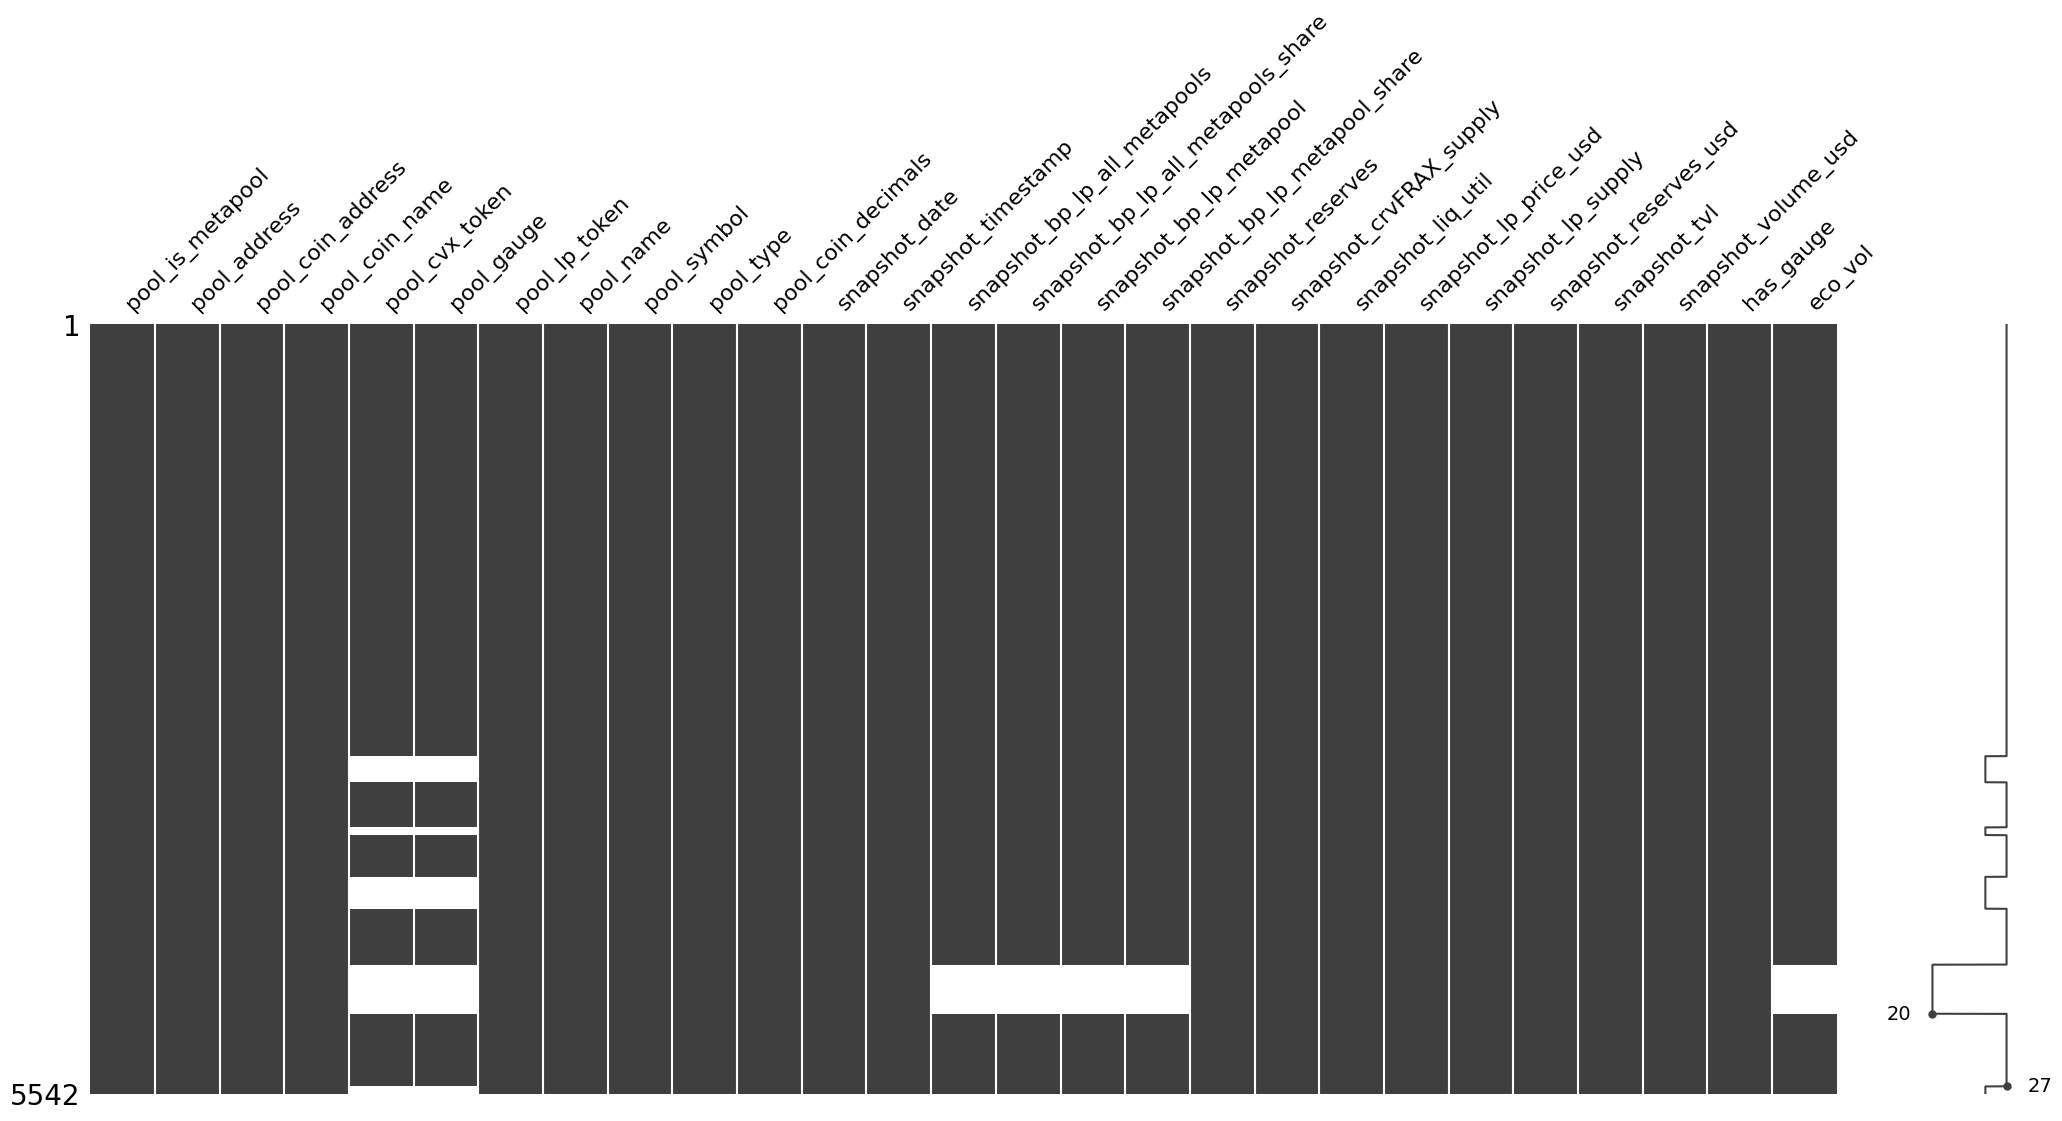

In [18]:
miss.matrix(df_pool_snaps)
df_pool_snaps.head()

In [19]:
# TODO: Show top 19 and aggregate others into single "Other" category.
df_bp_share = (
    df_pool_snaps.loc[(df_pool_snaps.pool_is_metapool == True) & (df_pool_snaps.pool_coin_name == 'crvFRAX')]
    [['snapshot_timestamp', 'pool_symbol', 'snapshot_bp_lp_metapool', 'snapshot_bp_lp_metapool_share', 
    'snapshot_bp_lp_all_metapools', 'snapshot_bp_lp_all_metapools_share']]
)
df_bp_share_last = df_bp_share.loc[df_bp_share.snapshot_timestamp == df_bp_share.snapshot_timestamp.max()]

### (Chart) Metapool TVL Share 

- Segmented by pool name 

In [20]:
# Table of most recent values 
# d = df_bp_share_last.copy()
# d.snapshot_bp_lp_metapool_share = d.snapshot_bp_lp_metapool_share * 100
# ddf(d.sort_values('snapshot_bp_lp_metapool_share', ascending=False).reset_index(drop=True))

# TODO: Change from pool symbol to pool name 

color = alt.Color("pool_symbol:N", scale=alt.Scale(range=colors_24))

chart_share_of_fraxbp = (
    alt.Chart(df_bp_share)
    .mark_area()
    .encode(
        x=alt.X('snapshot_timestamp:T', title="timestamp"), 
        y=alt.Y('snapshot_bp_lp_metapool_share:Q', axis=alt.Axis(format=",%", title="% FraxBP")), 
        color=color, 
        tooltip=["pool_symbol:N", alt.Tooltip('snapshot_bp_lp_metapool_share:Q', format=".1%", title='% FraxBP')]
    )
    .properties(title="Historical Metapool % FraxBP")
) 
chart_share_of_fraxbp_current = (
    alt.Chart(df_bp_share_last)
    .mark_arc()
    .encode(
        theta='snapshot_bp_lp_metapool_share:Q', 
        color=color, 
        tooltip=["pool_symbol:N", alt.Tooltip('snapshot_bp_lp_metapool_share:Q', format=".1%", title='% FraxBP')]
    )
    .properties(title="Current Metapool % FraxBP")
)

chart_metapool_share = (
    alt.Chart(df_bp_share)
    .mark_area()
    .encode(
        x=alt.X('snapshot_timestamp:T', title="timestamp"), 
        y=alt.Y('snapshot_bp_lp_all_metapools_share:Q', axis=alt.Axis(format=",%", title="% Across Metapools"), scale=alt.Scale(domain=[0,1])), 
        color=color, 
        tooltip=["pool_symbol:N", alt.Tooltip('snapshot_bp_lp_all_metapools_share:Q', format=".1%", title='% Across Metapools')]
    )
    .properties(title="Historial Metapool Share Across All Metapools")
)

(chart_share_of_fraxbp | chart_share_of_fraxbp_current | chart_metapool_share)

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

### (Chart) Metapool TVL

- Faceted by pool 
- Segmented by token 

### (Chart) Metapool TVL Breakdown

- Faceted by pool type 
- Segmented by pool name  

In [21]:
ddf(df_pool_snaps.head(1))

In [22]:
# Data for charts 
df_tvl = df_pool_snaps.loc[
    (df_pool_snaps.pool_coin_name != 'crvFRAX') & (df_pool_snaps.pool_type != "REGISTRY_V1")
]
# df_tvl = df_tvl.drop(columns="snapshot_date")

df_tvl['pool_name'] = df_tvl.pool_name.apply(lambda s: s.split(':')[1].strip())

# Shared chart config 
x = alt.X("snapshot_timestamp:T", axis=alt.Axis(title="Timestamp"))
color = alt.Color("pool_name:N", scale=alt.Scale(range=colors_28))
facet = alt.Facet('pool_type:N', columns=1, header=alt.Header(title=None, labels=False))

# Charts 
chart_tvl_type_breakdown = (
    alt.Chart(df_tvl)
    .transform_aggregate(groupby=['snapshot_timestamp', 'pool_type'], tvl_pool_type="sum(snapshot_reserves_usd)")
    .transform_joinaggregate(groupby=['snapshot_timestamp'], tvl_total="sum(tvl_pool_type)")
    .encode(
        x=x, 
        tooltip=[
            "pool_type:N",
            alt.Tooltip("tvl_pool_type:Q", format="$,d"), 
            alt.Tooltip("tvl_total:Q", format="$,d")
        ]
    )
)
chart_tvl_type_breakdown_area = (
    chart_tvl_type_breakdown
    .mark_area()
    .encode(
        y=alt.Y("tvl_pool_type:Q", axis=alt.Axis(title="TVL ($)")), 
        color="pool_type:N",
    )
)
chart_tvl_type_breakdown_line = (
    chart_tvl_type_breakdown
    .mark_line()
    .encode(y="tvl_total:Q")
)

alt.vconcat(
    alt.hconcat(
        (
            alt.Chart(df_tvl)
            .mark_area()
            .encode(
                x=x,
                y=alt.Y("snapshot_reserves_usd:Q", axis=alt.Axis(title="TVL ($)")), 
                facet=facet, 
                color=color, 
                tooltip=[
                    "pool_name:N", 
                    alt.Tooltip("snapshot_reserves_usd:Q", format="$,d")
                ]
            )
            .resolve_scale(y="independent").resolve_axis("independent")
            .properties(title="Historical Metapool TVL Breakdown")
        ), 
        (
            alt.Chart(
                df_tvl.loc[df_tvl.snapshot_timestamp == df_tvl.snapshot_timestamp.max()]
            )
            .mark_arc()
            .encode(
                theta="snapshot_reserves_usd:Q", 
                color=color, 
                facet=facet, 
                tooltip=[
                    "pool_name:N", 
                    alt.Tooltip("snapshot_reserves_usd:Q", format="$,d", title="TVL"),
                ] 
            )
            .resolve_scale(theta="independent")
            .properties(title="Current Metapool TVL Breakdown")
        )
    ),
    alt.layer(chart_tvl_type_breakdown_area, chart_tvl_type_breakdown_line), 
    center=True
).resolve_legend(color="independent").resolve_scale(color="independent")

/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/1762949151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tvl['pool_name'] = df_tvl.pool_name.apply(lambda s: s.split(':')[1].strip())
/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

### Snapshot Proposals 

We retrieve all snapshot proposals for convex gauge weight snapshots. 

Since votium bribes are intended to get vlCVX holders to vote for particular choices in this snapshot, this data is necessary. 

In [23]:
@task(persist_result=True, cache_key_fn=lambda *args: "snapshot_proposals")
async def query_snapshot_proposals(): 
    """Get all snapshot proposals corresponding to convex gauge weight votes. 
    
    Within each gauge weight vote, holders of vlCVX collectively determine how convex should distribute it's 
    veCRV in subsequent curve gauge votes. 
    
    - Votes are pulled from the snapshot graphql endpoint. 
    """
    proposal_attrs = ['id', 'title', 'choices', 'start', 'end', 'state']
    proposals = await graphql_execute(
        URL_SNAPSHOT, 
        '''
        query Proposals {
          proposals(
            first: 10000,
            where: {space: "cvx.eth"},
            orderBy: "created",
            orderDirection: asc
          ) {
            <proposal_attrs>
          }
        }
        '''.replace('<proposal_attrs>', '\n'.join(proposal_attrs))
    )
    # Number of rounds here should match number of rounds on llama airforce 
    # https://llama.airforce/#/bribes/rounds/votium/cvx-crv/
    df_proposals = pd.DataFrame(proposals)
    df_proposals.title = df_proposals.title.str.lower()
    df_proposals = df_proposals.loc[~df_proposals.title.str.startswith("(test)") & df_proposals.title.str.contains("gauge weight")]
    df_proposals.start = pd.to_datetime(df_proposals.start, unit='s').dt.date
    df_proposals.end = pd.to_datetime(df_proposals.end, unit='s').dt.date 
    df_proposals = df_proposals.sort_values('start').reset_index(drop=True)
    # On votium, the proposal id is keccak256 hashed. So we need to perform this operation on the data pulled from snapshot 
    df_proposals['id_keccak256'] = df_proposals.id.apply(
        lambda _id: Web3.keccak(text=_id).hex() if not _id.startswith('0x') else Web3.keccak(hexstr=_id).hex()
    )
    # Validate that this query pulls in all data by ensuring that the number of votium voting rounds we get from this query 
    # matches the expected number of voting rounds, which we can compute using simple timedelta logic, the date of the 
    # first vote, and the current date. 
    dmin = pd.Timestamp('2021-09-16') # day of the first votium snapshot 
    assert pd.Timestamp(df_proposals.start.min()) == dmin
    actual_dates = df_proposals.sort_values('start')['start']
    expected_dates = pd.Series([d.date() for d in pd.date_range(pd.Timestamp('2021-09-16'), pd.Timestamp.now(), freq='14D')])
    pd.testing.assert_series_equal(actual_dates.iloc[:len(expected_dates)], expected_dates, check_names=False)
    # Sometimes, snapshot proposals for a week are posted the night before the week begins. This allows some lee-way 
    assert abs(len(actual_dates) - len(expected_dates)) <= 1
    df_proposals = df_proposals.rename(columns={
        'id': 'proposal_id', 
        'title': 'proposal_title', 
        'choices': 'proposal_choices', 
        'start': 'proposal_start', 
        'end': 'proposal_end', 
        'id_keccak256': 'proposal_id_keccak256'
    })
    df_proposals = df_proposals.sort_values('proposal_start').reset_index(drop=True).reset_index()
    df_proposals['proposal_round'] = df_proposals['index'] + 1 
    df_proposals = df_proposals.drop(columns=['index', 'state']) 
    return df_proposals 
    
@task(persist_result=True, cache_key_fn=lambda *args: "snapshot_votes4")
async def query_snapshot_votes(proposal_ids, verbose=True): 
    """Get all votes for all convex gauge weight snapshot proposals. 
        
    - Votes are pulled from the snapshot graphql endpoint. 
    """
    votes = await graphql_execute(
        URL_SNAPSHOT, 
        '''
            query Votes($page_size: Int!, $page_offset: Int!, $proposal_ids: [String]!) {
              votes (
                first: $page_size
                skip: $page_offset
                where: { proposal_in: $proposal_ids }
              ) {
                proposal { id }
                id
                voter
                created
                choice
                vp
                vp_state
              }
            }
        ''', 
        paginate=True, 
        page_size=SNAPSHOT_API_MAX_RECORDS_PER_REQUEST,
        variable_values={'proposal_ids': proposal_ids}, 
        verbose=True, 
    )
    vote_records = []
    for v in votes: 
        for index, amount in v['choice'].items(): 
            # TODO: data validation step / what does vp_state on this entity mean? Sometimes it's pending but still seems to be counted in votes. 
            # assert v['vp_state'] == 'final'
            r = {
                **v, 
                'choice_index': int(index) - 1, # convert 1 to 0 based indexing for join with other data later 
                'choice_weight': amount, 
                'is_votium': v['voter'].lower() == VOTIUM_VOTER
            }
            del r['choice'] 
            vote_records.append(r)
    df_votes = pd.DataFrame(vote_records)
    df_votes['proposal_id'] = df_votes.proposal.apply(lambda v: v['id']) 
    # So choice weights are really weird on snapshot. The best way to normalize is to find all votes 
    # by a voter in a proposal, sum the weights to get a total, then use this to find the fraction of 
    # the users total voting power (vp) allocated to the choices they voted for. 
    df_votes['choice_weight_total'] = df_votes.groupby(['proposal_id', 'voter'])['choice_weight'].transform('sum')
    df_votes['choice_percent'] = df_votes.choice_weight / df_votes.choice_weight_total * 100
    df_votes['choice_vp'] = (df_votes.choice_percent / 100) * df_votes.vp 
    df_votes = df_votes.drop(columns=['proposal', 'vp_state', 'choice_weight_total', 'choice_weight']) 
    df_votes = df_votes.rename(columns={'created': 'vote_created', 'vp': 'total_vp', 'id': 'vote_id'})
    return df_votes

@task(persist_result=True, cache_key_fn=lambda *args: "gauge_results")
def query_gauge_info(): 
    # Most recent gauge information. We will map the name of all the current gauges to the names 
    # within the snapshot proposal, so we can determine which choices in the proposals correspond 
    # to which gauges. 
    gauge_data = requests.get('https://api.curve.fi/api/getAllGauges').json()
    df_gauges = pd.DataFrame([
        {
          'gauge_name': d['name'].lower(), 
          'gauge_short_name': d['shortName'].lower(), 
          'gauge_address': d['gauge']
        } 
        for _, d in gauge_data['data'].items() 
    ])
    return df_gauges 

@task(persist_result=True, cache_key_fn=lambda *args: 'votium_epoches')
def query_votium_epoches(): 
    # Get all votium voting epochs. Once we have validated that this set of epochs matches our set of snapshot proposals, 
    # we need to merge this data with our snapshot proposal data. 
    query_epoches = sg_votium.Query.epoches(first=1000, orderBy="initiatedAt", where={"bribeCount_gt": 0})
    df_epoches = query_attrs(sg, query_epoches, ['id', 'initiatedAt', 'deadline'])
    df_epoches = df_cols_change_prefix(df_epoches, 'epoches', 'epoch')
    df_epoches = df_cols_camel_to_snake(df_epoches) 
    df_epoches['epoch_start_date'] = pd.to_datetime(df_epoches.epoch_initiated_at, unit="s").dt.date
    df_epoches['epoch_end_date'] = pd.to_datetime(df_epoches.epoch_deadline, unit="s").dt.date 
    return df_epoches 

@task(persist_result=True, cache_key_fn=lambda *args: 'votium_bribes')
def query_votium_bribes(epoch_ids): 
    # https://github.com/convex-community/convex-subgraph/blob/main/subgraphs/votium/src/mapping.ts
    # Addresses associated with the frax protocol used for votium bribes 
    # TODO: Frax controls some subset of the TVL in it's liquidity pools. Need to be cognizant of this because it leads 
    #       to a rebate the lowers the cost of bribing. 
    # TODO: Frax's vlCVX is not custodied in the investor custodian wallet. 
    token_map = {ADDRESS_FXS: 'FXS', ADDRESS_FRAX: 'FRAX'}
    query_bribes = sg_votium.Query.bribes(first=100000, where={
        "epoch_in": epoch_ids, "token_in": [ADDRESS_FXS, ADDRESS_FRAX]
    })
    df_bribes = query_attrs(sg, query_bribes, ['id', 'amount', 'token', 'choiceIndex', 'epoch.id'])
    df_bribes = df_cols_change_prefix(df_bribes, "bribes", "bribe")
    df_bribes = df_cols_camel_to_snake(df_bribes)
    df_bribes['bribe_token_name'] = df_bribes.bribe_token.apply(lambda addr: token_map[addr])
    df_bribes['bribe_tx_hash'] = df_bribes.bribe_id.apply(lambda _id: _id.split('-')[0])
    df_bribes.bribe_amount /= 1e18 # both frax and fxs have 18 decimals
    df_bribes = df_bribes.drop(columns=['bribe_id'])
    return df_bribes 

@task(persist_result=True, cache_key_fn=lambda *args: 'bribe_asset_prices')
def query_bribe_asset_prices():
    token_addr_map = {'frax': ADDRESS_FRAX, 'fxs': ADDRESS_FXS}
    df_prices = cg_get_market_history(cg, token_addr_map, include_volume=False, include_market_cap=False)
    df_prices = (
        df_prices
        .drop(columns='date')
        .pivot(index="timestamp", columns="token_name", values="prices")
        .reset_index().rename(columns={'frax': 'price_frax', 'fxs': 'price_fxs'})
    )
    return df_prices 

@task 
def validate_proposals_vs_epoches(df_proposals, df_epoches): 
    """We pull epoches from the votium subgraph, and snapshot proposals from the snapshot api. 
    
    We need to ensure that we have a one to one mapping between these two entites. 
    Additionally, we remove one erroneous proposal from our set of epoches 
    """
    # Validate that the epoch dates for votium bribes match the proposal data we pulled from snapshot. `
    epoch_dates = df_epoches.epoch_start_date.unique().tolist()
    proposal_dates = df_proposals.proposal_start.unique().tolist()
    d_exclude = pd.Timestamp('2021-11-08').date()
    assert d_exclude in epoch_dates and not d_exclude in proposal_dates
    epoch_dates.remove(d_exclude)
    assert set(epoch_dates) == set(proposal_dates)
    df_epoches = df_epoches.loc[df_epoches.epoch_start_date != d_exclude].reset_index(drop=True)
    return df_epoches

@task 
def process_df_epoches(df): 
    df = (
        df.sort_values('epoch_start_date').reset_index(drop=True).reset_index().rename(columns={'index': 'proposal_round'})
    )
    df.proposal_round += 1
    df = df.drop(columns=['epoch_initiated_at', 'epoch_deadline'])
    df.epoch_start_date = pd.to_datetime(df.epoch_start_date)
    df.epoch_end_date = pd.to_datetime(df.epoch_end_date)
    return df 

@task(cache_key_fn=task_input_hash)
def label_bribes(df_bribes): 
    # Label bribes from known frax associated addresses 
    def get_tx_from(tx_hash): 
        # Determine the "from" address for the transaction that contained the bribe 
        return w3.eth.get_transaction(tx_hash)['from'] 

    # compute mapping of tx_hash to the from address of the transaction 
    tx_hashes = df_bribes.bribe_tx_hash.unique()
    tx_from_map = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = {tx_hash: executor.submit(get_tx_from, tx_hash) for tx_hash in tx_hashes}
        for tx_hash, future in futures.items(): 
            tx_from_map[tx_hash] = future.result()

    frax_bribe_addresses = [
        # ('comptroller', '0xb1748c79709f4ba2dd82834b8c82d4a505003f27'),
        # ('cvx locker amo', '0x7038c406e7e2c9f81571557190d26704bb39b8f3'),
        ('investor custodian', '0x5180db0237291A6449DdA9ed33aD90a38787621c'),
        ('frax1.eth', '0x234D953a9404Bf9DbC3b526271d440cD2870bCd2'),
    ]
    address_labels = {addr.lower(): name for name, addr in frax_bribe_addresses}

    df_bribes['bribe_from'] = df_bribes['bribe_tx_hash'].apply(lambda tx_hash: tx_from_map[tx_hash])
    df_bribes['briber_label'] = df_bribes['bribe_from'].apply(lambda a: address_labels.get(a.lower(), 'unknown'))

    label_counts = df_bribes.briber_label.value_counts(dropna=False)
    print("Label count for addresses submitting bribes") 
    print(label_counts)

    return df_bribes 
        
@task 
def join_bribes_choices_epoches_prices(df_bribes, df_choices, df_epoches, df_prices): 
    df = (
        # Aggregate bribes by unique combination of proposal, briber, bribe token, bribe choice index 
        df_bribes.groupby([
            'bribe_epoch_id', 'bribe_choice_index', 'bribe_token', 'bribe_token_name', 'bribe_from', 'briber_label'
        ])
        ['bribe_amount'].sum().reset_index()
    )
    plen = len(df)
    df = (
        df
        # Join in epoch, so we know the time period of voting (for visualizing a time axis) 
        .merge(
            df_epoches[['proposal_round', 'epoch_id', 'epoch_start_date', 'epoch_end_date']].rename(columns={'epoch_id': 'bribe_epoch_id'}), 
            how='left', 
            on='bribe_epoch_id', 
            validate='m:1'
        )
        # Join in choice information, so we know what was bribed for 
        .merge(
            df_choices[['proposal_round', 'choice', 'choice_index']].rename(columns={'choice_index': 'bribe_choice_index', 'choice': 'bribe_choice'}), 
            how='left',
            on=['proposal_round', 'bribe_choice_index'],
            validate='m:1',
        )
    )
    assert plen == len(df)

    # Append price data for FRAX and FXS so we can denominate bribes in $
    # For pricing, we use the price of the assets on the day the bribing period ends. 
    # If the bribing period is still active, then we use the most recent price. 
    df['price_timestamp'] = df.epoch_end_date
    df.loc[df.price_timestamp >= df_prices.timestamp.max(), 'price_timestamp'] = df_prices.timestamp.max()
    df = df.sort_values('price_timestamp').reset_index(drop=True)
    df = pd.merge_asof(df, df_prices, left_on="price_timestamp", right_on="timestamp")
    df['bribe_amount_usd'] = None 
    mask_fxs = df.bribe_token_name == 'FXS'
    mask_frax = df.bribe_token_name == 'FRAX'
    df.loc[mask_fxs, 'bribe_amount_usd'] = df.loc[mask_fxs].bribe_amount * df.loc[mask_fxs].price_fxs
    df.loc[mask_frax, 'bribe_amount_usd'] = df.loc[mask_frax].bribe_amount * df.loc[mask_frax].price_frax
    df = df.drop(columns=['price_timestamp', 'price_frax', 'price_fxs', 'timestamp'])

    df = df_sort_cols(df, ['proposal', 'bribe', 'choice', 'epoch']) 
    
    return df 
    
@task 
def standardize_choices(df_votium_frax, df_gauges): 
    # Goal: For each choice in the snapshot proposal (i.e. a curve pool gauge), we want to pair the 
    #       choice name taken from the snapshot API with the address of the curve pool that choice 
    #       corresponds to. 
            
    # Remove irrelevant gauges  
    remove_choices = [
        "arbitrum-f-4pool", # 4pool never launched 
        "tusd", # Only bribed for in 1 round. Not really sure what to do about this one 
        "ypool", # Single tiny bribe in round 13, not sure what this is.  
    ]
    df_votium_frax = df_votium_frax.loc[~df_votium_frax.bribe_choice.isin(remove_choices)]
    
    # We get the current set of gauges from the curve API. These names are what appear in the snapshot proposal 
    # This will get the most recent set of names but the structure of the names has changed over time. More work 
    # needs to be done to account for historical differences in naming pools 
    canonical_choices = {
        l[0]: l[1] for l in [
            ['frax', 'frax+3crv (0xd632…)'], 
            ['d3pool', 'frax+fei+alusd (0xbaaa…)'], 
            ['fpifrax', 'frax+fpi (0xf861…)'], 
            ['2pool-frax', 'frax+usdc (0xdcef…)'], 
            ['fraxbpsusd', 'susd+fraxbp (0xe3c1…)'], 
            ['fraxbplusd', 'lusd+fraxbp (0x497c…)'], 
            ['fraxbpbusd', 'busd+fraxbp (0x8fdb…)'], 
            ['fraxbpape', 'apeusd+fraxbp (0x04b7…)'], 
            ['fraxbpalusd', 'alusd+fraxbp (0xb30d…)'], 
            ['fraxbpusdd', 'usdd+fraxbp (0x4606…)'], 
            ['fraxbptusd', 'tusd+fraxbp (0x33ba…)'], 
            ['fraxbpgusd', 'gusd+fraxbp (0x4e43…)'], 
        ]
    }
    
    def preprocess_choice(choice):
        choice = choice.lower()
        # Some older voting rounds used crvfrax while newer ones use fraxbp 
        choice = choice.replace('crvfrax', 'fraxbp')
        # Some older voting rounds prefixed factory pools with f- while newer rounds do not
        if choice.startswith("f-"): 
            choice = choice[2:]
        # Some older voting rounds showed addresses in form (0x...ab123)
        # whereas newer rounds use the form (0x...) without trailing values. 
        # Here, we remove trailing values if they exist 
        m = re.search('.*\\u2026([^\)]*)\)$', choice)
        if m: 
            choice = choice.replace(m.group(1), '') 
        if choice in canonical_choices: 
            return canonical_choices[choice] 
        return choice 
    
    df_votium_frax.bribe_choice = df_votium_frax.bribe_choice.apply(preprocess_choice)
    
    # Ensure that the same canonical choice doesn't have two different choice indices in a given round 
    numeric_cols = ['bribe_amount', 'bribe_amount_usd']
    group_cols = [c for c in df_votium_frax.columns if c not in numeric_cols and c not in ['bribe_choice_index']]
    assert all(len(gdf) == 1 for _, gdf in df_votium_frax.groupby(group_cols))
    # Ensure that all choices across all rounds were mapped to a canonical choice 
    assert not set(df_votium_frax.bribe_choice.unique()).difference(set(df_gauges.gauge_short_name.unique()))
    
    df = df_votium_frax.merge(df_gauges, how='left', left_on='bribe_choice', right_on='gauge_short_name')
    assert all(~df.gauge_short_name.isna()) 
    
    return df 

@task
def proposals_to_choices(df_proposals): 
    # Expand the proposals table so that we have one row per combination of a proposal and a choice within that proposal. 
    df_choices = df_proposals.explode('proposal_choices').reset_index().rename(columns={'proposal_choices': 'choice'})
    df_choices['choice_index'] = df_choices.groupby('proposal_id').cumcount()
    df_choices = df_choices[['choice', 'choice_index', 'proposal_round', 'proposal_title', 'proposal_id', 'proposal_id_keccak256']]
    df_choices['choice'] = df_choices.choice.str.lower()
    return df_choices 


<>:327: DeprecationWarning: invalid escape sequence '\)'
<>:327: DeprecationWarning: invalid escape sequence '\)'
/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/2538663647.py:327: DeprecationWarning: invalid escape sequence '\)'
  m = re.search('.*\\u2026([^\)]*)\)$', choice)


In [72]:
@flow(cache_result_in_memory=False)
async def flow_votium_votes(): 
    # COINGECKO DATA 
    # ----------------------------------------------------------------
    df_prices = query_bribe_asset_prices.submit()

    # CURVE DATA 
    # ----------------------------------------------------------------
    df_gauge_info = query_gauge_info.submit()
    
    # SNAPSHOT DATA 
    # ----------------------------------------------------------------
    df_proposals = await query_snapshot_proposals()
    df_choices = proposals_to_choices(df_proposals)
    print(f"Number of votium snapshot proposals: {len(df_proposals)}")
    proposal_ids = df_proposals.proposal_id.unique().tolist()
    df_votes = await query_snapshot_votes(proposal_ids) # convex gauge votes 
    # Join votes with the choice metadata from the snapshot proposal 
    df_votes = df_votes.merge(df_choices, how='left', on=['proposal_id', 'choice_index'], validate="m:1")
    assert not df_votes.proposal_title.isna().any() # ensures each vote was matched with a proposal 
    
    # VOTIUM DATA 
    # ----------------------------------------------------------------
    df_epoches = query_votium_epoches() 
    df_epoches = validate_proposals_vs_epoches(df_proposals, df_epoches)
    df_epoches = process_df_epoches(df_epoches) # must happen after validation to remove erroneous proposal 
    epoch_ids = df_epoches.epoch_id.unique().tolist()
    df_bribes = query_votium_bribes(epoch_ids)
    df_bribes = label_bribes(df_bribes)

    # Data Joins / Processing 
    # ----------------------------------------------------------------
    # Takes each bribe in fxs or frax and joins the name of the choice voted for, voting round, and prices for reward tokens 
    df_votium_frax = join_bribes_choices_epoches_prices(df_bribes, df_choices, df_epoches, df_prices)
    # Ensures that historical choices map to choices in most recent proposal 
    df_votium_frax = standardize_choices(df_votium_frax, df_gauge_info) 
    
    return df_proposals, df_bribes, df_choices, df_votes, df_epoches, df_prices.result(), df_votium_frax, df_gauge_info.result()


/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/prefect/flows.py:205: UserWarning: A flow named 'flow-votium-votes' and defined at '/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/2520753140.py:1' conflicts with another flow. Consider specifying a unique `name` parameter in the flow definition:

 `@flow(name='my_unique_name', ...)`
  warnings.warn(


In [73]:
df_proposals, df_bribes, df_choices, df_votes, df_epoches, df_prices, df_votium_frax, df_gauge_info = await flow_votium_votes()

18:24:56.065 | INFO    | prefect.engine - Created flow run 'daffodil-frigatebird' for flow 'flow-votium-votes'

18:24:56.116 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'query_snapshot_proposals-2630bb84-0' for task 'query_snapshot_proposals'

18:24:56.117 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'query_snapshot_proposals-2630bb84-0' immediately...

18:24:56.131 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'query_bribe_asset_prices-f0f27a15-0' for task 'query_bribe_asset_prices'

18:24:56.133 | INFO    | Flow run 'daffodil-frigatebird' - Submitted task run 'query_bribe_asset_prices-f0f27a15-0' for execution.

18:24:56.151 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'query_gauge_info-c42e0607-0' for task 'query_gauge_info'

18:24:56.152 | INFO    | Flow run 'daffodil-frigatebird' - Submitted task run 'query_gauge_info-c42e0607-0' for execution.

18:24:56.166 | INFO    | Task run 'query_snapshot_proposals-2630bb84-0' - Finished in state Cached(type=COMPLETED)

18:24:56.177 | INFO    | Task run 'query_bribe_asset_prices-f0f27a15-0' - Finished in state Cached(type=COMPLETED)

18:24:56.187 | INFO    | Task run 'query_gauge_info-c42e0607-0' - Finished in state Cached(type=COMPLETED)

18:24:56.208 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'proposals_to_choices-e8dff6d1-0' for task 'proposals_to_choices'

18:24:56.209 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'proposals_to_choices-e8dff6d1-0' immediately...

18:24:56.255 | INFO    | Task run 'proposals_to_choices-e8dff6d1-0' - Finished in state Completed()

Number of votium snapshot proposals: 33


18:24:56.267 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'query_snapshot_votes-834d480d-0' for task 'query_snapshot_votes'

18:24:56.268 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'query_snapshot_votes-834d480d-0' immediately...

18:24:56.280 | INFO    | Task run 'query_snapshot_votes-834d480d-0' - Finished in state Cached(type=COMPLETED)

18:24:56.354 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'query_votium_epoches-d4330e84-0' for task 'query_votium_epoches'

18:24:56.355 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'query_votium_epoches-d4330e84-0' immediately...

18:24:56.365 | INFO    | Task run 'query_votium_epoches-d4330e84-0' - Finished in state Cached(type=COMPLETED)

18:24:56.387 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'validate_proposals_vs_epoches-ac2ae3a8-0' for task 'validate_proposals_vs_epoches'

18:24:56.388 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'validate_proposals_vs_epoches-ac2ae3a8-0' immediately...

18:24:56.412 | INFO    | Task run 'validate_proposals_vs_epoches-ac2ae3a8-0' - Finished in state Completed()

18:24:56.422 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'process_df_epoches-891f5b9e-0' for task 'process_df_epoches'

18:24:56.423 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'process_df_epoches-891f5b9e-0' immediately...

18:24:56.448 | INFO    | Task run 'process_df_epoches-891f5b9e-0' - Finished in state Completed()

18:24:56.458 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'query_votium_bribes-82e77013-0' for task 'query_votium_bribes'

18:24:56.459 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'query_votium_bribes-82e77013-0' immediately...

18:24:56.469 | INFO    | Task run 'query_votium_bribes-82e77013-0' - Finished in state Cached(type=COMPLETED)

18:24:56.489 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'label_bribes-7d1640f6-0' for task 'label_bribes'

18:24:56.490 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'label_bribes-7d1640f6-0' immediately...

18:24:56.500 | INFO    | Task run 'label_bribes-7d1640f6-0' - Finished in state Cached(type=COMPLETED)

18:24:56.518 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'join_bribes_choices_epoches_prices-3b15ab58-0' for task 'join_bribes_choices_epoches_prices'

18:24:56.518 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'join_bribes_choices_epoches_prices-3b15ab58-0' immediately...

18:24:56.557 | INFO    | Task run 'join_bribes_choices_epoches_prices-3b15ab58-0' - Finished in state Completed()

18:24:56.567 | INFO    | Flow run 'daffodil-frigatebird' - Created task run 'standardize_choices-e0fce205-0' for task 'standardize_choices'

18:24:56.567 | INFO    | Flow run 'daffodil-frigatebird' - Executing 'standardize_choices-e0fce205-0' immediately...

/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_94965/2538663647.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votium_frax.bribe_choice = df_votium_frax.bribe_choice.apply(preprocess_choice)


18:24:56.604 | INFO    | Task run 'standardize_choices-e0fce205-0' - Finished in state Completed()

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/prefect/utilities/asyncutils.py:233: UserWarning: `sync` called from an asynchronous context; you should `await` the async function directly instead.
  warnings.warn(
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x29ecf60e0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x29d265180>


18:24:56.713 | INFO    | Flow run 'daffodil-frigatebird' - Finished in state Completed()

In [26]:
(
    alt.Chart((
        df_votes[['proposal_round', 'choice', 'choice_vp']]
        .groupby(['proposal_round', 'choice']).sum()
        .reset_index() 
    ))
    .mark_bar()
    .encode(
        x="proposal_round:O", 
        y="choice_vp:Q", 
        color="choice:N", 
        tooltip=["choice:N", "choice_vp:Q"]
    )
    .properties(title="Convex Gauge Weight Vote", width=500) 
)

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [45]:
first_row(data)

In [69]:

first_row(data_mp)

In [75]:
df_proposals.head()
df_proposals = pd.to_datetime(df_proposals

proposal_id  \
0  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
1  QmTQBqsG7dW93xX8zBZnevMa1mbEmDHUx7QabAYyn6mFJi   
2  QmaS9vd1vJKQNBYX4KWQ3nppsTT3QSL3nkz5ZYSwEJk6hZ   
3  QmacSRTG62rnvAyBuNY3cVbCtBHGV8PuGRoL32Dm6MPy5y   
4  QmPSBg5aTPb82sZRqF9ouUQQ5CkbpRaJMdHYUMieN3dpqv   

                           proposal_title  \
0  gauge weight for week of 16th sep 2021   
1  gauge weight for week of 30th sep 2021   
2  gauge weight for week of 14th oct 2021   
3  gauge weight for week of 28th oct 2021   
4  gauge weight for week of 11th nov 2021   

                                    proposal_choices proposal_start  \
0  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-09-16   
1  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-09-30   
2  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-10-14   
3  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-10-28   
4  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-11-11   

  proposal_end                              proposal_id_keccak256  \
0   2021-09-21  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...   
1   2021-10-05  0xe11de27c199ddee0966ed8b24e1ee34bd3363f0fe09f...   
2   2021-10-19  0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...   
3   2021-11-02  0xb439c625f9f4929f6b486f79d5ae6850971d179a0887...   
4   2021-11-16  0x77cebe9bd4bc9836f115774c7387839e77abe3dda613...   

   proposal_round  
0               1  
1               2  
2               3  
3               4  
4               5

In [92]:
df_pool_snaps.head()

pool_is_metapool                                pool_address  \
0              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4              True  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                            pool_coin_address pool_coin_name  \
0  0xff709449528b6fb6b88f557f7d93dece33bca78d         ApeUSD   
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc        crvFRAX   
2  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc        crvFRAX   
3  0xff709449528b6fb6b88f557f7d93dece33bca78d         ApeUSD   
4  0xff709449528b6fb6b88f557f7d93dece33bca78d         ApeUSD   

                               pool_cvx_token  \
0  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
1  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
2  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
3  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   
4  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   

                                   pool_gauge  \
0  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
1  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
2  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
3  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   
4  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   

                                pool_lp_token  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                     pool_name     pool_symbol pool_type  ...  \
0  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
1  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
2  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
3  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   
4  Curve.fi Factory USD Metapool: apeUSDFRAXBP  APEUSDBP3CRV-f    STABLE  ...   

         snapshot_reserves snapshot_crvFRAX_supply snapshot_liq_util  \
0                        0            1.045613e+07               0.0   
1                        0            1.045613e+07               0.0   
2                        0            3.291364e+07               0.0   
3                        0            3.291364e+07               0.0   
4  66889500035284223924072            9.002223e+07               0.0   

  snapshot_lp_price_usd snapshot_lp_supply snapshot_reserves_usd  \
0              0.000000           0.000000              0.000000   
1              0.000000           0.000000              0.000000   
2              0.000000           0.000000              0.000000   
3              0.000000           0.000000              0.000000   
4              0.999028      118465.162979          66782.220309   

    snapshot_tvl snapshot_volume_usd  has_gauge      eco_vol  
0       0.000000            0.000000       True  3025.983529  
1       0.000000            0.000000       True     0.000000  
2       0.000000         7649.840571       True     0.000000  
3       0.000000         7649.840571       True  1650.747269  
4  118349.963483            0.000000       True   684.142599  

[5 rows x 27 columns]

In [96]:
color = alt.Color('gauge_short_name:N', scale=alt.Scale(range=colors_28))


def chart_bribes_historical(df): 
    return (
        alt.Chart(df)
        .transform_joinaggregate(groupby=['proposal_round'], bribe_amount_total_usd="sum(bribe_amount_usd)")
        .mark_bar()
        .encode(
            x="proposal_round:O", 
            y="bribe_amount_usd:Q", 
            color=color, 
            tooltip=[
                alt.Tooltip('epoch_end_date:T'), 
                alt.Tooltip('gauge_short_name:N'), 
                alt.Tooltip('bribe_token_name:N'),
                alt.Tooltip('bribe_amount:Q', format=",d"),
                alt.Tooltip('bribe_amount_usd:Q', format="$,d"),
                alt.Tooltip('bribe_amount_total_usd:Q', format="$,d"), 
            ]
        )
    )
    
    
def chart_bribes_last_round(df): 
    return (
        alt.Chart(df)
        .mark_arc()
        .encode(
            theta="bribe_amount_usd:Q", 
            color=color, 
            tooltip=['gauge_short_name:N', alt.Tooltip('bribe_amount_usd:Q', format="$,d")]
        )
    )


data = df_votium_frax.copy()
metapool_gauge_addrs = df_pool_snaps.loc[df_pool_snaps.pool_is_metapool == True].pool_gauge.unique()
data['is_metapool'] = data.gauge_address.apply(lambda addr: addr in metapool_gauge_addrs)

last_round = data.proposal_round.max()
data_last = data.loc[data.proposal_round == last_round]
data_mp = data.loc[data.is_metapool == True] 
data_mp_last = data_mp.loc[data.proposal_round == last_round]

dfp = df_proposals.copy()
dfp.proposal_end = pd.to_datetime(dfp.proposal_end)

d = (
    df_pool_snaps.loc[(
        df_pool_snaps.pool_is_metapool == True) & 
        (df_pool_snaps.pool_coin_name != 'crvFRAX') 
    ]
    .merge(dfp[['proposal_round', 'proposal_end']], how='left', left_on='snapshot_date', right_on='proposal_end')
    .merge(df_gauge_info, how='left', left_on='pool_gauge', right_on='gauge_address')
)
d = d.loc[~d.proposal_end.isna()]

first_row(d)

# TODO: Bribe for FraxBP in round 26 was using cvxCRV, why is this? 
(
    (chart_bribes_historical(data) | chart_bribes_last_round(data_last)) & 
    (chart_bribes_historical(data_mp) | chart_bribes_last_round(data_mp_last)).resolve_scale(theta='independent', color="shared") & 
    (
        alt.Chart(d)
        .mark_bar()
        .encode(
            x="proposal_round:O", 
            y="snapshot_bp_lp_all_metapools_share:Q", 
            color=color, 
        )
    )
)

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [28]:
# ddf(df_votium_frax)

In [29]:
first_row(df_pool_snaps)
first_row(df_votium_frax)

In [30]:
# data.head()


In [31]:
# Charts here validated by going to https://curve.fi/#/ethereum/pools
# entering "fraxbp" into the search bar and comparing the tvl of all pools in the UI 
# to the tvl in the charts seen here. 
data = df_pool_snaps.loc[df_pool_snaps.pool_is_metapool == True]
ncols = 1 
rows = []
row = []
pool_names = df_pool_snaps.pool_name.unique().tolist()

# Amount of usd bribes per gauge and round (identified by timestamp) 
df_bribe_gauge_round = df_votium_frax.groupby(['gauge_address', 'epoch_start_date', 'epoch_end_date'])['bribe_amount_usd'].sum().reset_index()

groups = list(data.groupby("pool_name"))
def group_sort_key(g): 
    # Sort by tvl at last time point 
    gdf = g[1]
    return -1 * gdf.loc[gdf.snapshot_timestamp == gdf.snapshot_timestamp.max(), 'snapshot_reserves_usd'].sum()
groups.sort(key=group_sort_key)

for pool_name, sdf in groups: 
    sdf = sdf[[
        'pool_name', 'pool_gauge', 'snapshot_timestamp', 'snapshot_reserves_usd', 'snapshot_tvl', 
        'pool_coin_name', 'snapshot_volume_usd', 'snapshot_liq_util', 'eco_vol', 
    ]]
    sdf = sdf.merge(
        df_bribe_gauge_round, 
        how='left', 
        left_on=['pool_gauge', 'snapshot_timestamp'], 
        right_on=['gauge_address', 'epoch_end_date'], 
    )
    paired_asset = [e for e in sdf.pool_coin_name.unique() if e != 'crvFRAX'][0]
    
    # For each bribe on the current pool, what is the ratio of bribe / avg_tvl_next_two_weeks mea
    dfb = sdf.loc[sdf.pool_coin_name == 'crvFRAX']
    df_ranges = (
        df_bribe_gauge_round[['epoch_start_date', 'epoch_end_date']]
        .drop_duplicates()
        .sort_values('epoch_start_date').reset_index(drop=True)
    )
    df_ranges['next_epoch_tvl'] = 0
    # map each epoch start to tvl over course of next two weeks 
    epoch_start_to_epoch_tvl = {}
    epoch_end_to_next_epoch_start = {}
    for r in df_ranges.to_dict(orient="records"): 
        s = r['epoch_start_date']
        e = r['epoch_end_date'] 
        df_ranges.loc[df_ranges.epoch_start_date == s, 'next_epoch_tvl'] = (
            dfb.loc[(dfb.snapshot_timestamp >= s) & (dfb.snapshot_timestamp < e)].snapshot_tvl.mean()
        )
    df_ranges = df_ranges.dropna()
    
    # Match each bribe with the tvl of the pool over the next epoch 
    dfb = dfb.merge(df_ranges[['epoch_start_date', 'next_epoch_tvl']], how='left', on='epoch_start_date')
    # Compute ratio of average tvl of pool over next epoch to the bribe 
    dfb['tvl_to_bribe_ratio'] = dfb.next_epoch_tvl / dfb.bribe_amount_usd
    
    # Chart showing TVL in the pool 
    tvl_base = (
        alt.Chart(sdf)
        .transform_calculate(stack_order="datum.pool_coin_name === 'crvFRAX' ? 0 : 1")
        .transform_joinaggregate(groupby=['pool_name', 'snapshot_timestamp'], tvl_total="sum(snapshot_reserves_usd)")
        .encode(x="snapshot_timestamp:T", order="stack_order:O", )
    )
    chart_tvl_area = (
        tvl_base
        .mark_area()
        .encode(
            y=alt.Y("snapshot_reserves_usd:Q", axis=alt.Axis(title="TVL ($)")), 
            color=alt.Color("pool_coin_name:N", scale=alt.Scale(range=colors_28)), 
            tooltip=[
                alt.Tooltip("pool_coin_name:N"), 
                alt.Tooltip("snapshot_reserves_usd:Q", format='$,d'), 
                alt.Tooltip("tvl_total:Q", format='$,d'), 
            ]
        )
    )
    chart_tvl_line = (
        tvl_base
        .transform_filter("datum.pool_coin_name == 'crvFRAX'")
        .mark_line()
        .encode(y="tvl_total:Q")
    )
    chart_pool_liquidity = alt.layer(chart_tvl_area, chart_tvl_line)
    # Chart showing volume in the pool 
    vol_base = (
        alt.Chart(sdf)
        .transform_filter("datum.pool_coin_name !== 'crvFRAX'")
        .encode(x="snapshot_timestamp:T", order="stack_order:O")
    )
    chart_vol_bar = (
        vol_base
        .mark_bar()
        .encode(
            y="snapshot_volume_usd:Q", 
            tooltip=[
                alt.Tooltip("snapshot_volume_usd:Q", format='$,d'), 
            ]
        )
    )
    # Chart showing liquidity utilization in the pool 
    chart_liq_util = (
        vol_base
        .mark_line()
        .encode(
            y=alt.Y("snapshot_liq_util:Q", scale=alt.Scale(domain=[0,1.0], clamp=True)), 
            tooltip=[
                alt.Tooltip("snapshot_liq_util:Q", format='$,d'), 
            ]
        )
    )
    # Chart showing ecosystem wide tvl for non crvFRAX assets 
    chart_vol_total = (
        vol_base
        .mark_bar()
        .encode(
            y="eco_vol:Q", 
            tooltip=[
                alt.Tooltip("eco_vol:Q", format='$,d'), 
            ]
        )
    )
    # Chart showing ecosystem wide tvl for non crvFRAX assets 
    chart_bribes = (
        vol_base
        .mark_point()
        .encode(
            y="bribe_amount_usd:Q", 
            tooltip=[
                alt.Tooltip("bribe_amount_usd:Q", format='$,d'), 
            ]
        )
    )
    chart_bribe_ratio = (
        alt.Chart(dfb.loc[~dfb.tvl_to_bribe_ratio.isna()])
        .mark_line()
        .encode(
            x="snapshot_timestamp:T",
            y="tvl_to_bribe_ratio:Q", 
            tooltip=[
                alt.Tooltip("tvl_to_bribe_ratio:Q", format='.2f'), 
            ]
        )
    )

    pool_symbol = pool_name.split(':')[-1].strip()
    w = 250
    h = 150
    
    row.append(
        alt.hconcat(
            chart_pool_liquidity.properties(title=f"TVL: {pool_symbol}", width=w, height=h), 
            chart_liq_util.properties(title=f"Liquidity Utilization (Curve): {pool_symbol}", width=w, height=h), 
            chart_vol_bar.properties(title=f"Volume (Curve): {pool_symbol}", width=w, height=h), 
            chart_vol_total.properties(title=f"Total Volume (Ecosystem): {paired_asset}", width=w, height=h), 
            chart_bribes.properties(title=f"Votium Bribes: {pool_symbol}", width=w, height=h), 
            chart_bribe_ratio.properties(title=f"Votium Bribes Ratio: {pool_symbol}", width=w, height=h), 
            bounds='flush', 
            spacing=75
        )
        .resolve_scale(x="shared")
    )
    if len(row) == ncols: 
        rows.append(row) 
        row = []
    
rows = [
    alt.hconcat(*row) 
    .resolve_scale(x="shared")
    for row in rows
]
chart = (
    alt.vconcat(*rows)
    .resolve_scale(x="shared")
)
chart

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [32]:
# metapool_gauge_snaps = df_pool_snaps.loc[
#     (df_pool_snaps.pool_is_metapool == True) & (~df_pool_snaps.pool_gauge.isna())
# ]
# metapool_bribes = df.loc[df.gauge_address.isin(metapool_gauge_snaps.pool_gauge)]

# df_full = (
#     pd.merge(
#         metapool_gauge_snaps, 
#         metapool_bribes,
#         how='left',
#         left_on=['snapshot_timestamp', 'pool_gauge'],
#         right_on=['timestamp', 'gauge_address'], 
#     )
# )
# miss.matrix(df_full)
# ddf(df_full.head())

In [33]:
# (
#     alt.Chart(df_full)
#     .mark_bar()
#     .encode(
#         x="snapshot_timestamp:O", 
#         y="bribe_amount_usd:Q", 
#         color="pool_symbol:N",
#     )
# ) | (
#     alt.Chart(df_full.loc[~df_full.proposal_round.isna()])
#     .mark_bar()
#     .encode(
#         x="snapshot_timestamp:O", 
#         y="snapshot_bp_lp_all_metapools_share:Q", 
#         color="pool_symbol:N",
#     )
# )

In [34]:
# df_liquidity.dailyPoolSnapshots_timestamp = pd.to_datetime(df_liquidity.dailyPoolSnapshots_timestamp, unit='s')
# df_liquidity = df_liquidity[
#     ['dailyPoolSnapshots_timestamp', 'dailyPoolSnapshots_reservesUSD', 'pool_address', 'pools_name', 'pools_lpToken', 'pools_coins', 'pools_coinNames']
# ]
# df_liquidity.head()

In [35]:
# # Map each bribe to liquidty data point for it's corresponding pool 
# dff_join = pd.merge_asof(
#     df.sort_values('timestamp').reset_index(drop=True),
#     df_liquidity.sort_values('dailyPoolSnapshots_timestamp').reset_index(drop=True),
#     left_by=['gauge_address'], 
#     right_by=['pool_address'], 
#     left_on=['timestamp'], 
#     right_on=['dailyPoolSnapshots_timestamp', ], 
# )[['proposal_round', 'dailyPoolSnapshots_timestamp', 'gauge_short_name', 'bribe_fxs', 'gauge_address']]
# dff_join = dff_join.loc[~dff_join.dailyPoolSnapshots_timestamp.isna()]
# print(len(dff_join))
# dff_join.head()

In [36]:
# df_liquidity.head()

In [37]:
# dff_join.head()

In [38]:
# dff = (
#     # 1. Ensure that the gauge information is attached to liquidity data 
#     df_liquidity
#     .merge(
#         dff_join[['gauge_short_name', 'gauge_address']].drop_duplicates().reset_index(drop=True), 
#         how='left', 
#         left_on='pool_address', 
#         right_on='gauge_address'
#     ) 
#     .merge(
#         dff_join[['gauge_address', 'bribe_fxs', 'proposal_round', 'dailyPoolSnapshots_timestamp']], 
#         how='left', 
#         left_on=['pool_address', 'dailyPoolSnapshots_timestamp'], 
#         right_on=['gauge_address', 'dailyPoolSnapshots_timestamp'], 
#     ) 
#     .drop(columns=['gauge_address_y'])
# ) 
# dff = dff.loc[~dff.gauge_short_name.isna()]

# # dff.bribe_fxs = dff.bribe_fxs.fillna(0)
# # miss.matrix(dff) 
# print(len(df_liquidity))
# print(len(dff))

# dff.head()

In [39]:
# base = (
#     alt.Chart(dff)
#     .transform_calculate(stack_order="datum.pools_coinNames === 'crvFRAX' ? 0 : 1")
#     .encode(
        
#         color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
#         tooltip=alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format='$,d'), 
#         facet=alt.Facet('pools_symbol:N', columns=3),
#         order="stack_order:O", 
#     )
#     .resolve_scale(y="independent")
# )
# liquidity = (
#     base
#     .mark_area()
#     .encode(
#         x="dailyPoolSnapshots_timestamp:T", 
#         y="dailyPoolSnapshots_reservesUSD:Q"
#     )
#     # .resolve_scale(y="independent")
# )
# bribes = (
#     base
#     .mark_bar()
#     .encode(
#         x="dailyPoolSnapshots_timestamp:T", 
#         y="bribe_fxs:Q",
#     )
#     .resolve_scale(y="independent")
# )

# # miss.matrix(dff)

# liquidity | bribes 

In [40]:
# ncols = 3 
# rows = []
# row = []
# gnames = dff.gauge_short_name.unique().tolist()

# max_tvl = (
#     dff.groupby(['dailyPoolSnapshots_timestamp', 'gauge_short_name'])['dailyPoolSnapshots_reservesUSD'].sum().max()
# )
# max_bribe = (
#     dff['bribe_fxs'].max() 
# )

# while gnames: 
#     gname = gnames.pop()
#     # add data for this gauge to current row 
#     sdf = dff.loc[dff.gauge_short_name == gname] 
#     base = (
#         alt.Chart(sdf)
#         .transform_calculate(stack_order="datum.pools_coinNames === 'crvFRAX' ? 0 : 1")
#         .encode(
#             x="dailyPoolSnapshots_timestamp:T", 
#             color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
#             order="stack_order:O", 
#         )
#         .properties(width=250, height=150) 
#     )
#     liquidity = base.mark_area().encode(
#         y=alt.Y("dailyPoolSnapshots_reservesUSD:Q", scale=alt.Scale(domain=[0, max_tvl * 1.05])),
#         tooltip=alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format='$,d'), 
#     )
#     bribes = (
#         base
#         .transform_filter("datum.pools_coinNames === 'crvFRAX'")
#         .mark_bar()
#         .encode(
#             y=alt.Y("bribe_fxs:Q", scale=alt.Scale(domain=[0, max_bribe * 1.05])),
#             tooltip=alt.Tooltip("bribe_fxs:Q", format=',d'), 
#         )
#     )
#     row.append(alt.vconcat(liquidity, bribes).resolve_scale(x="shared").resolve_axis(x='shared'))
#     if len(row) == ncols: 
#         rows.append(row) 
#         row = []
    
# rows = [alt.hconcat(*row) for row in rows]
# chart = alt.vconcat(*rows)    
# chart


In [41]:
# sdf[~sdf.bribe_fxs.isna()].head()

# miss.matrix(sdf)
# ddf(df_liquidity.loc[df_liquidity.pools_coinNames == 'ApeUSD'].head(20))